In [90]:
import pandas as pd
import numpy as np
# from google.colab import drive

In [89]:
test = pd.read_csv('ONTO2050LAAresults20181010.csv')
test

,Unnamed: 0,Unnamed: 1,TOTAL HOUSEHOLDS,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 18,Unnamed: 19,TOTAL EMPLOYMENT (WAGE & SALARY),Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,CCA,COMMUNITY AREA NAME,2015,2020,2025,2030,2035,2040,2045,2050,...,2050,NaN,2015,2020,2025,2030,2035,2040,2045,2050
1,14,Albany Park,"16,693","16,974","17,170","17,199","17,131","17,084","17,061","17,045",...,"52,591",NaN,"6,036","6,153","6,301","6,455","6,466","6,478","6,489","6,501"
2,57,Archer Heights,"3,883","4,121","4,411","4,625","4,650","4,681","4,682","4,683",...,"15,189",NaN,"9,620","10,008","10,132","10,346","10,513","10,661","10,789","10,960"
3,34,Armour Square,"5,599","5,996","6,349","6,587","6,677","6,685","6,683","6,693",...,"15,716",NaN,"5,370","5,626","5,715","5,797","5,850","5,858","5,863","5,868"
4,70,Ashburn,"12,843","13,191","13,609","14,198","14,810","15,083","15,220","15,267",...,"46,648",NaN,"5,087","5,303","5,541","5,922","6,393","6,915","7,031","7,227"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,65,West Lawn,"8,727","8,995","9,320","9,683","9,994","10,146","10,267","10,373",...,"37,805",NaN,"6,525","6,756","6,919","7,172","7,520","7,823","8,070","8,285"
74,53,West Pullman,"9,226","9,784","10,534","11,406","12,239","13,021","13,510","13,777",...,"38,059",NaN,"1,242","1,368","1,538","1,713","1,976","2,279","2,646","2,809"
75,2,West Ridge,"25,213","25,671","26,283","26,846","27,275","27,388","27,374","27,373",...,"75,409",NaN,"13,077","13,439","13,666","13,964","14,342","14,576","14,589","14,603"
76,24,West Town,"40,192","43,151","44,200","44,132","44,120","43,667","43,319","43,279",...,"95,516",NaN,"43,887","45,235","45,695","46,065","46,369","46,569","46,585","46,602"


In [91]:
# Load data without google

# MCMF
df = pd.read_csv('convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')
population_df = pd.read_csv('chicago_population.CSV', ';').T
headers = population_df.iloc[0]

# Population data
population_df = pd.DataFrame(population_df.values[1:], columns=headers)
population_df['name'] = population_df['name'].str.upper().str.replace("'", "")

/Users/lukelilienthal/opt/anaconda3/envs/main/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (14,28,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**LOAD DATA**

In [2]:
# load MCMF data
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv('/content/drive/MyDrive/STAT 390/convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')

Mounted at /content/drive


<ipython-input-2-752693068698>:3: DtypeWarning: Columns (14,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/STAT 390/convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')


In [4]:
# load population data (used to calculate per capita metrics)
population_df = pd.read_csv('/content/drive/MyDrive/STAT 390/chicago_population.CSV', ';').T
headers = population_df.iloc[0]
population_df = pd.DataFrame(population_df.values[1:], columns=headers)
population_df['name'] = population_df['name'].str.upper().str.replace("'", "")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/STAT 390/chicago_population.CSV'

In [7]:
population_df.head(5)

Community Area,name,population,income,latinos,blacks,white,asian,other
0,ROGERS PARK,54991,39482,0.244,0.263,0.393,0.064,0.036
1,WEST RIDGE,71942,47323,0.204,0.111,0.427,0.225,0.032
2,UPTOWN,56362,40324,0.142,0.2,0.516,0.114,0.028
3,LINCOLN SQUARE,39493,57749,0.191,0.038,0.631,0.111,0.029
4,NORTH CENTER,31867,81524,0.136,0.023,0.773,0.045,0.022


In [4]:
temp1 = df['Geographic Cluster Name'].sort_values().unique()
temp1

array(['ALBANY PARK', 'ARCHER HEIGHTS', 'ARMOUR SQUARE', 'ASHBURN',
       'AUBURN GRESHAM', 'AUSTIN', 'AVALON PARK', 'AVONDALE',
       'BELMONT CRAGIN', 'BEVERLY', 'BRIDGEPORT', 'BRIGHTON PARK',
       'BURNSIDE', 'Back of the Yards', 'Bronzeville/South Lakefront',
       'CALUMET HEIGHTS', 'CHATHAM', 'CHICAGO LAWN', 'CLEARING',
       'DOUGLAS', 'DUNNING', 'EAST GARFIELD PARK', 'EAST SIDE',
       'EDGEWATER', 'EDISON PARK', 'ENGLEWOOD', 'FOREST GLEN',
       'FULLER PARK', 'GAGE PARK', 'GARFIELD PARK', 'GARFIELD RIDGE',
       'GRAND BOULEVARD', 'GREATER GRAND CROSSING', 'HEGEWISCH',
       'HERMOSA', 'HUMBOLDT PARK', 'HYDE PARK', 'IRVING PARK',
       'JEFFERSON PARK', 'KENWOOD', 'LAKE VIEW', 'LINCOLN PARK',
       'LINCOLN SQUARE', 'LOGAN SQUARE', 'LOOP', 'LOWER WEST SIDE',
       'Little Village', 'MCKINLEY PARK', 'MONTCLARE', 'MORGAN PARK',
       'MOUNT GREENWOOD', 'NEAR NORTH SIDE', 'NEAR SOUTH SIDE',
       'NEAR WEST SIDE', 'NORTH CENTER', 'NORTH LAWNDALE', 'NORTH PARK',
  

In [5]:
temp2 = population_df['name'].sort_values().unique()
temp2

array(['ALBANY PARK', 'ARCHER HEIGHTS', 'ARMOUR SQUARE', 'ASHBURN',
       'AUBURN GRESHAM', 'AUSTIN', 'AVALON PARK', 'AVONDALE',
       'BELMONT CRAGIN', 'BEVERLY', 'BRIDGEPORT', 'BRIGHTON PARK',
       'BURNSIDE', 'CALUMET HEIGHTS', 'CHATHAM', 'CHICAGO LAWN',
       'CLEARING', 'DOUGLAS', 'DUNNING', 'EAST GARFIELD PARK',
       'EAST SIDE', 'EDGEWATER', 'EDISON PARK', 'ENGLEWOOD',
       'FOREST GLEN', 'FULLER PARK', 'GAGE PARK', 'GARFIELD RIDGE',
       'GRAND BOULEVARD', 'GREATER GRAND CROSSING', 'HEGEWISCH',
       'HERMOSA', 'HUMBOLDT PARK', 'HYDE PARK', 'IRVING PARK',
       'JEFFERSON PARK', 'KENWOOD', 'LAKE VIEW', 'LINCOLN PARK',
       'LINCOLN SQUARE', 'LOGAN SQUARE', 'LOOP', 'LOWER WEST SIDE',
       'MCKINLEY PARK', 'MONTCLARE', 'MORGAN PARK', 'MOUNT GREENWOOD',
       'NEAR NORTH SIDE', 'NEAR SOUTH SIDE', 'NEAR WEST SIDE', 'NEW CITY',
       'NORTH CENTER', 'NORTH LAWNDALE', 'NORTH PARK', 'NORWOOD PARK',
       'OAKLAND', 'OHARE', 'PORTAGE PARK', 'PULLMAN', 'RIVERDALE',
 

In [5]:
population_df

Community Area,name,population,income,latinos,blacks,white,asian,other
0,ROGERS PARK,54991,39482,0.244,0.263,0.393,0.064,0.036
1,WEST RIDGE,71942,47323,0.204,0.111,0.427,0.225,0.032
2,UPTOWN,56362,40324,0.142,0.2,0.516,0.114,0.028
3,LINCOLN SQUARE,39493,57749,0.191,0.038,0.631,0.111,0.029
4,NORTH CENTER,31867,81524,0.136,0.023,0.773,0.045,0.022
...,...,...,...,...,...,...,...,...
72,WASHINGTON HEIGHTS,26493,42053,0.01,0.974,0.005,0,0.012
73,MOUNT GREENWOOD,19093,80505,0.072,0.052,0.86,0.007,0.01
74,MORGAN PARK,22544,56886,0.027,0.667,0.287,0.004,0.014
75,OHARE,12756,49601,0.095,0.032,0.772,0.083,0.019


In [90]:
set(temp1) ^ set(temp2)

{'Back of the Yards',
 'Bronzeville/South Lakefront',
 'DOUGLAS',
 'EAST GARFIELD PARK',
 'GARFIELD PARK',
 'GRAND BOULEVARD',
 'Little Village',
 'NEW CITY',
 'OAKLAND',
 'SOUTH LAWNDALE',
 'WEST GARFIELD PARK',
 nan}

In [92]:
# Standardize area names
replace_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront'}
replace_pop_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront', 'SOUTH LAWNDALE': 'Little Village', 'NEW CITY': 'Back of the Yards'}
df['Geographic Cluster Name'] = df['Geographic Cluster Name'].replace(replace_df)
population_df['name'] = population_df['name'].replace(replace_pop_df)

# Merge datasets
# merged_df = pd.merge(df, population_df, left_on = 'Geographic Cluster Name', right_on = 'name', how = 'left')

In [93]:
# Aggregate totals of grouped neighborhood names
population_df[['population', 'income', 'latinos', 'blacks', 'white', 'asian']] = population_df[['population', 'income', 'latinos', 'blacks', 'white', 'asian']].astype(float)

grouped_population_df = population_df.groupby('name').agg({'population': 'sum',
                                                            'income':'mean',
                                                            'latinos':'mean',
                                                            'blacks':'mean',
                                                            'white':'mean', 
                                                            'asian':'mean'}).reset_index()

# Merge datasets
merged_df = pd.merge(df, grouped_population_df, left_on = 'Geographic Cluster Name', right_on = 'name', how = 'left')

**PREPROCESSING**

In [94]:
# Discard programs with min age over 25
df = df.loc[df['Min Age'] <= 25]

# Record programs with max age over 25 as family programs
df['Family Program'] = (df['Max Age'] > 25).astype(bool)

# Make category names unique
category_dict = {'Building And Fixing Things': 'Building & Fixing Things', 
 'Computers.': 'Computers', 
 'Food.': 'Food',
 'Helping Your Community.': 'Helping Your Community',
 'Reading & Writing.': 'Reading & Writing',
 'Sports + Wellness.': 'Sports & Wellness',
 'Work + Career': 'Work & Career'
}

df['Category Name'] = df['Category Name'].replace(category_dict)

# Group category names by STEM
stem_categories = ['Computers', 'Science', 'Building & Fixing Things', 'Science & Math', 'Digital Media.', 'Nature.', 'Math']
df['STEM'] = df['Category Name'].isin(stem_categories)
df['STEM'] = df['STEM'].map({True: 'STEM', False: 'Non-STEM'})

# Group min and max age by quartile
df['Min Age Quartile'] = pd.cut(df['Min Age'], bins=[0, 10, 17, 99, 200], labels=['0-10', '11-17','18-99', '100-200'])
df['Max Age Quartile'] = pd.cut(df['Max Age'], bins=[0, 3, 6, 13, 25], labels=['0-3', '4-6', '7-13','14-25'])

# Cost binary
df['Free'] = np.where(df['Program Price'] == 'Free', 'Free', 'Not Free')

merged_df = pd.merge(df, grouped_population_df, left_on = 'Geographic Cluster Name', right_on = 'name', how = 'left')

In [97]:
merged_df

,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Min Age Quartile,Max Age Quartile,Free,name,population,income,latinos,blacks,white,asian
0,"4,568",78752,NaN,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Academic Support,2000.0,7,15,...,0-10,14-25,Free,NEAR WEST SIDE,54881.0,62770.0,0.092,0.315,0.420,0.146
1,"4,569",78752,NaN,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Work + Career,2000.0,7,15,...,0-10,14-25,Free,NEAR WEST SIDE,54881.0,62770.0,0.092,0.315,0.420,0.146
2,"4,562",78749,https://cityoflearning-uploads.s3.amazonaws.co...,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Academic Support,100.0,12,18,...,11-17,14-25,Free,NORTH LAWNDALE,35912.0,25797.0,0.060,0.914,0.014,0.002
3,"4,563",78749,https://cityoflearning-uploads.s3.amazonaws.co...,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Music & Art.,100.0,12,18,...,11-17,14-25,Free,NORTH LAWNDALE,35912.0,25797.0,0.060,0.914,0.014,0.002
4,"4,557",78746,https://cityoflearning-uploads.s3.amazonaws.co...,Refugee Youth Career Pathways,Refugee Youth Career Pathways (RYCP) provides ...,RefugeeOne,Managing Money.,15.0,16,24,...,11-17,14-25,Free,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84601,"77,070",148925,https://cityoflearning-uploads.s3.amazonaws.co...,Medicina Scholars,<p>The Medicina Scholars program is designed t...,Hispanic Center of Excellence at UIC,Healthcare,NaN,18,24,...,18-99,14-25,Free,NEAR WEST SIDE,54881.0,62770.0,0.092,0.315,0.420,0.146
84602,"75,634",146348,https://cityoflearning-uploads.s3.amazonaws.co...,Park Cleanup at Kelvyn Park,"<p ""="""">Teens can get service hours through th...",Hermosa Neighborhood Association,Helping Your Community,NaN,4,65,...,0-10,NaN,Free,HERMOSA,25010.0,42418.0,0.874,0.030,0.076,0.012
84603,"75,635",146348,https://cityoflearning-uploads.s3.amazonaws.co...,Park Cleanup at Kelvyn Park,"<p ""="""">Teens can get service hours through th...",Hermosa Neighborhood Association,Nature.,NaN,4,65,...,0-10,NaN,Free,HERMOSA,25010.0,42418.0,0.874,0.030,0.076,0.012
84604,"75,638",146350,https://cityoflearning-uploads.s3.amazonaws.co...,Park Cleanup at Kelvyn Park,"<p ""="""">Teens can get service hours through th...",Hermosa Neighborhood Association,Helping Your Community,NaN,4,65,...,0-10,NaN,Free,HERMOSA,25010.0,42418.0,0.874,0.030,0.076,0.012


**ANALYSIS**

In [55]:
# Exploring null values
df.isnull().sum()

# Examining the two observations without category names
df.loc[df['Program Name'] == 'Grab & Go Meals for Children & Teens']
df.loc[df['Program Name'] == 'Trunk or Treat at Shabbona']

# Examining observations with missing Geographic cluster names
geonan = df.loc[df['Geographic Cluster Name'].isnull()]
geonan.isnull().sum()

# Checking observations without geographic cluster name and no online address
geoonlinenan = geonan.loc[geonan['Online Address'].isnull()].groupby(by = 'Category Name')
num = geoonlinenan['Category Name'].count()

# Checking the actual category names
categories = df.groupby(by = 'Category Name')
categories['Category Name'].count()

# Locating observations with min_age = 25
df['Min Age'].dtype
df.loc[df['Min Age'] == 25]

,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Program Pays Participants,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food,Family Program,STEM,Min Age Quartile,Max Age Quartile
12050,"11,579",85023,NaN,Game Room at Hamilton,Challenge your friends to more than just board...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.762798,-87.637703,False,True,Non-STEM,18-99,NaN
15844,"16,008",89171,NaN,Basketball - Open at Addams #SpringForward,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN
16789,"16,703",89798,NaN,Game Room at Hamilton,Challenge your friends to more than just board...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.762798,-87.637703,False,True,Non-STEM,18-99,NaN
17021,"18,207",90776,NaN,Pickleball at Gompers,Pickleball is a racquet sport which combines e...,Chicago Park District,Sports & Wellness,4.0,25,99,...,Not Paid,NO,NO,41.975800,-87.734398,False,True,Non-STEM,18-99,NaN
17029,"18,274",90838,NaN,Roller Skating at Ada,Adults skate around the park for recreational fun,Chicago Park District,Sports & Wellness,15.0,25,99,...,Not Paid,NO,NO,41.688400,-87.655998,False,True,Non-STEM,18-99,NaN
17778,"18,208",90777,NaN,Pickleball at Gompers,Pickleball is a racquet sport which combines e...,Chicago Park District,Sports & Wellness,4.0,25,99,...,Not Paid,NO,NO,41.975800,-87.734398,False,True,Non-STEM,18-99,NaN
18119,"16,009",89172,NaN,Basketball - Open at Addams,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN
18639,"18,209",90778,NaN,Pickleball at Gompers,Pickleball is a racquet sport which combines e...,Chicago Park District,Sports & Wellness,4.0,25,99,...,Not Paid,NO,NO,41.975800,-87.734398,False,True,Non-STEM,18-99,NaN
19413,"16,010",89173,NaN,Basketball - Open at Addams,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN
19724,"16,011",89174,NaN,Basketball - Open at Addams,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN


,Geographic Cluster Name,STEM,Free,Meeting Type,Total Programs,Total Capacity,Average Max Age,Average Latitude,Average Capacity,name,population,income,latinos,blacks,white,asian
0,ALBANY PARK,Non-STEM,Free,face_to_face,175,40139.0,41.068571,41.967482,229.365714,ALBANY PARK,51542.0,46198.0,0.494,0.040,0.292,0.144
1,ALBANY PARK,Non-STEM,Not Free,face_to_face,248,3384.0,28.177419,41.972663,13.645161,ALBANY PARK,51542.0,46198.0,0.494,0.040,0.292,0.144
2,ALBANY PARK,Non-STEM,Not Free,online,1,10.0,12.000000,41.973728,10.000000,ALBANY PARK,51542.0,46198.0,0.494,0.040,0.292,0.144
3,ALBANY PARK,STEM,Free,face_to_face,8,4279.0,48.750000,41.968608,534.875000,ALBANY PARK,51542.0,46198.0,0.494,0.040,0.292,0.144
4,ALBANY PARK,STEM,Not Free,face_to_face,7,54.0,33.285714,41.973709,7.714286,ALBANY PARK,51542.0,46198.0,0.494,0.040,0.292,0.144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,WOODLAWN,Non-STEM,Free,online,5,175.0,52.800000,41.795475,35.000000,WOODLAWN,23740.0,27413.0,0.021,0.868,0.068,0.023
430,WOODLAWN,Non-STEM,Not Free,face_to_face,249,3375.0,65.835341,41.781179,13.554217,WOODLAWN,23740.0,27413.0,0.021,0.868,0.068,0.023
431,WOODLAWN,Non-STEM,Not Free,online,23,332.0,55.869565,41.781738,14.434783,WOODLAWN,23740.0,27413.0,0.021,0.868,0.068,0.023
432,WOODLAWN,STEM,Free,face_to_face,5,250.0,48.800000,41.778427,50.000000,WOODLAWN,23740.0,27413.0,0.021,0.868,0.068,0.023


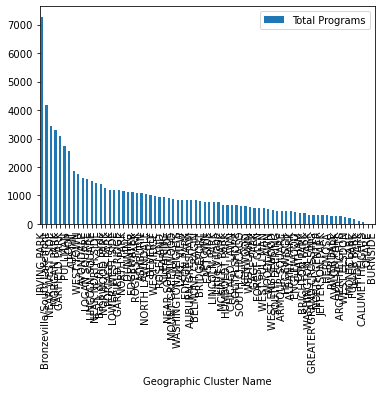

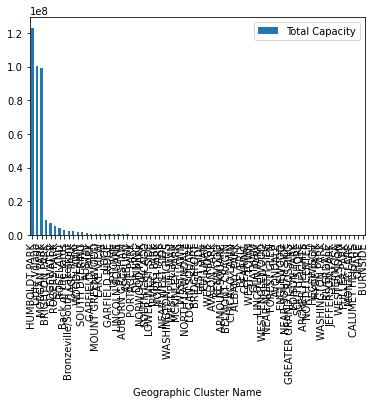

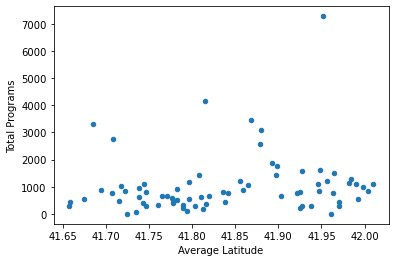

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

clusters = merged_df.groupby('Geographic Cluster Name').agg({'Geographic Cluster Name': 'count', 'Capacity':'sum', 'Max Age':'mean', 'Latitude':'mean'})
clusters.columns = ['Total Programs', 'Total Capacity', 'Average Max Age', 'Average Latitude']
clusters['Average Capacity'] = clusters['Total Capacity'] / clusters['Total Programs']
clusters.sort_values('Total Programs', inplace=True, ascending=False)
clusters.reset_index(inplace=True)

# Train on total capacity for different program types?
    # Cluster, Type, 
    # Make a binary column for online/in-person
    
# Add population for per capita

clusters.plot.bar(x='Geographic Cluster Name', y='Total Programs')
clusters.sort_values('Total Capacity', ascending=False).plot.bar(x='Geographic Cluster Name', y='Total Capacity')
clusters.plot(kind='scatter', x='Average Latitude', y='Total Programs')

# Train on total capacity for different program types

    ## Important Predictors- what to group by?
    # Cluster (location)
    # Category (make subcategories?)
    # Binary online/in-person
    
    ## Other features to create/use?
    # Time of the year?
    # Price?
    
    ## 
    # Other predictors?
    # Other metrics/interactions to analyze?

grouped = merged_df.groupby(['Geographic Cluster Name', 'STEM', 'Free','Meeting Type']).agg({'Geographic Cluster Name': 'count', 'Capacity':'sum', 'Max Age':'mean', 'Latitude':'mean'})
grouped.columns = ['Total Programs', 'Total Capacity', 'Average Max Age', 'Average Latitude']
grouped['Average Capacity'] = grouped['Total Capacity'] / grouped['Total Programs']


grouped.reset_index(inplace=True)

grouped['Geographic Cluster Name'] = grouped['Geographic Cluster Name'].replace(replace_df)


# This grouped dataframe will evolve with new enigneered predictors and metrics. We will use this as out training data to assess equity moving forward
merge = pd.merge(grouped, grouped_population_df, left_on = 'Geographic Cluster Name', right_on = 'name', how = 'left')
merge

In [108]:
## Hardship Score
## Equity index - how do we model areas of need\n",
# 2016-2020 Chicago Community Hardship Index : Percent Values 2016-2020,
hardship = pd.read_csv('Hardship_Index.csv')
hardship['Community Area'] = hardship['Community Area'].str.upper()

In [109]:
hardship = hardship.replace({'\$': ''}, regex=True)
hardship = hardship.replace({'\%': ''}, regex=True)
hardship = hardship.replace({'\,': ''}, regex=True)
hardship.drop(['No.', 'Unnamed: 9'], axis=1, inplace=True)
hardship

,Community Area,Percent of rowded Housing,Percent of Households With Income Below Poverty Level,Unemployment Rate for Population over 16,Percent Aged 25 and Over with no High School Diploma,Percent of Population Under Age 18 and Over Age 64,Per Capita Income,Hardship Index Score
0,ROGERS PARK,6.40,19.80,4.60,11.70,26.70,29682,40.9
1,WEST RIDGE,8.10,14.60,6.30,17.40,39.40,27671,52.1
2,UPTOWN,4.40,19.00,3.30,9.80,24.40,42112,32.4
3,LINCOLN SQUARE,2.30,8.20,5.40,6.40,26.30,49797,24.7
4,NORTH CENTER,0.90,5.50,3.20,3.40,34.30,77951,18.1
...,...,...,...,...,...,...,...,...
72,WASHINGTON HEIGHTS,0.80,20.00,14.20,11.40,40.00,24294,45.9
73,MOUNT GREENWOOD,2.10,5.80,4.40,4.70,38.30,41850,30.1
74,MORGAN PARK,1.00,11.60,10.60,6.30,40.30,34946,37.0
75,O'HARE,3.10,10.40,3.80,8.30,32.80,35715,32.7


In [110]:
# Standardize area names for hardship dataset
replace_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront'}
replace_hardship_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront', 'SOUTH LAWNDALE': 'Little Village', 'NEW CITY': 'Back of the Yards', 'LAKEVIEW': 'LAKE VIEW', "O'HARE":'OHARE', 'CLEARNING':'CLEARING'}
grouped['Geographic Cluster Name'] = grouped['Geographic Cluster Name'].replace(replace_df)
hardship['Community Area'] = hardship['Community Area'].replace(replace_hardship_df)

#Average metrics for same name areas
hardship.iloc[:,range(1,8)] = hardship.iloc[:,range(1,8)].astype(float)

grouped_hardship = hardship.groupby('Community Area').mean()

# Merge datasets
full_df = pd.merge(merge, grouped_hardship, left_on = 'Geographic Cluster Name', right_on = 'Community Area', how = 'left')

## Dataset Checks

In [113]:
full_df.drop('name', axis=1, inplace=True)
full_df

,Geographic Cluster Name,STEM,Free,Meeting Type,Total Programs,Total Capacity,Average Max Age,Average Latitude,Average Capacity,population,...,blacks,white,asian,Percent of rowded Housing,Percent of Households With Income Below Poverty Level,Unemployment Rate for Population over 16,Percent Aged 25 and Over with no High School Diploma,Percent of Population Under Age 18 and Over Age 64,Per Capita Income,Hardship Index Score
0,ALBANY PARK,Non-STEM,Free,face_to_face,175,40139.0,41.068571,41.967482,229.365714,51542.0,...,0.040,0.292,0.144,6.4,12.6,6.6,19.3,31.7,32298.0,44.8
1,ALBANY PARK,Non-STEM,Not Free,face_to_face,248,3384.0,28.177419,41.972663,13.645161,51542.0,...,0.040,0.292,0.144,6.4,12.6,6.6,19.3,31.7,32298.0,44.8
2,ALBANY PARK,Non-STEM,Not Free,online,1,10.0,12.000000,41.973728,10.000000,51542.0,...,0.040,0.292,0.144,6.4,12.6,6.6,19.3,31.7,32298.0,44.8
3,ALBANY PARK,STEM,Free,face_to_face,8,4279.0,48.750000,41.968608,534.875000,51542.0,...,0.040,0.292,0.144,6.4,12.6,6.6,19.3,31.7,32298.0,44.8
4,ALBANY PARK,STEM,Not Free,face_to_face,7,54.0,33.285714,41.973709,7.714286,51542.0,...,0.040,0.292,0.144,6.4,12.6,6.6,19.3,31.7,32298.0,44.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,WOODLAWN,Non-STEM,Free,online,5,175.0,52.800000,41.795475,35.000000,23740.0,...,0.868,0.068,0.023,4.0,31.1,15.9,12.7,33.8,22457.0,53.1
430,WOODLAWN,Non-STEM,Not Free,face_to_face,249,3375.0,65.835341,41.781179,13.554217,23740.0,...,0.868,0.068,0.023,4.0,31.1,15.9,12.7,33.8,22457.0,53.1
431,WOODLAWN,Non-STEM,Not Free,online,23,332.0,55.869565,41.781738,14.434783,23740.0,...,0.868,0.068,0.023,4.0,31.1,15.9,12.7,33.8,22457.0,53.1
432,WOODLAWN,STEM,Free,face_to_face,5,250.0,48.800000,41.778427,50.000000,23740.0,...,0.868,0.068,0.023,4.0,31.1,15.9,12.7,33.8,22457.0,53.1


In [115]:
full_df[full_df['Total Capacity'] == 0]

,Geographic Cluster Name,STEM,Free,Meeting Type,Total Programs,Total Capacity,Average Max Age,Average Latitude,Average Capacity,population,...,blacks,white,asian,Percent of rowded Housing,Percent of Households With Income Below Poverty Level,Unemployment Rate for Population over 16,Percent Aged 25 and Over with no High School Diploma,Percent of Population Under Age 18 and Over Age 64,Per Capita Income,Hardship Index Score
10,ARCHER HEIGHTS,STEM,Not Free,face_to_face,3,0.0,99.0,41.803501,0.0,13393.0,...,0.0100,0.2150,0.010,11.00,10.2,8.50,29.30,40.3,21399.0,62.9
35,AUSTIN,STEM,Free,online,1,0.0,24.0,NaN,0.0,98514.0,...,0.8510,0.0440,0.006,4.20,27.1,13.40,18.10,39.4,21385.0,56.1
36,AUSTIN,STEM,Not Free,face_to_face,51,0.0,99.0,41.890745,0.0,98514.0,...,0.8510,0.0440,0.006,4.20,27.1,13.40,18.10,39.4,21385.0,56.1
42,AVALON PARK,STEM,Not Free,face_to_face,4,0.0,99.0,41.743599,0.0,10185.0,...,0.9570,0.0080,0.002,1.70,16.0,15.70,9.60,42.3,29198.0,46.1
88,CALUMET HEIGHTS,STEM,Free,face_to_face,1,0.0,19.0,41.732761,0.0,13812.0,...,0.9340,0.0090,0.002,0.80,14.2,7.10,5.70,42.5,35884.0,36.5
135,ENGLEWOOD,STEM,Not Free,face_to_face,6,0.0,99.0,41.776699,0.0,30654.0,...,0.9740,0.0030,0.001,1.40,39.7,24.90,23.70,42.7,15034.0,68.2
144,FULLER PARK,STEM,Not Free,face_to_face,9,0.0,99.0,41.812099,0.0,2876.0,...,0.9220,0.0160,0.002,1.30,51.9,25.10,23.80,47.2,13982.0,75.1
151,GAGE PARK,STEM,Not Free,face_to_face,3,0.0,99.0,41.793499,0.0,39894.0,...,0.0540,0.0470,0.003,8.00,16.7,16.20,32.60,38.6,16155.0,66.4
159,GARFIELD PARK,STEM,Not Free,online,4,0.0,8.5,41.886631,0.0,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
168,GREATER GRAND CROSSING,Non-STEM,Free,online,1,0.0,99.0,NaN,0.0,32602.0,...,0.9690,0.0060,0.001,1.80,33.1,19.80,13.50,40.4,19735.0,57.1


In [116]:
df[df['Capacity'] == 0]

,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food,Family Program,STEM,Min Age Quartile,Max Age Quartile,Free
9,66,76861,https://cityoflearning-uploads.s3.amazonaws.co...,ConTextos Open Cyber Circle,Open Cyber Circle is an online space for our c...,DYN Tech!,Reading & Writing,0.0,3,100,...,NO,NO,NaN,NaN,False,True,Non-STEM,0-10,NaN,Free
10,23,76830,https://cityoflearning-uploads.s3.amazonaws.co...,Free Virtual Family Yoga,FREE Virtual Family Yoga\r\nwith Serendipity Y...,Homewood Science Center,Sports & Wellness,0.0,2,99,...,NO,NO,NaN,NaN,False,True,Non-STEM,0-10,NaN,Free
20,25,76832,https://cityoflearning-uploads.s3.amazonaws.co...,Online Live-stream K-12 STEM Classes,Our 75-minute online classes are designed to e...,Digital Adventures,Computers,0.0,7,18,...,NO,NO,NaN,NaN,False,False,STEM,0-10,14-25,Not Free
21,"4,570",78753,https://cityoflearning-uploads.s3.amazonaws.co...,Headspace Take Ten,While we may all be separated from one another...,Headspace Take Ten,Sports & Wellness,0.0,0,100,...,NO,NO,NaN,NaN,False,True,Non-STEM,NaN,NaN,Free
27,60,76858,https://cityoflearning-uploads.s3.amazonaws.co...,Virtual Cooking Classes by iCook,"iCook At Home is a fun, hands-on interactive c...",DYN Tech!,Food,0.0,5,12,...,NO,NO,NaN,NaN,False,False,Non-STEM,0-10,7-13,Not Free
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83742,"84,823",156484,NaN,Film Screening: Book Club (2018),Join King Branch for a screening of Book Club ...,Chicago Public Library,Music & Art.,0.0,13,99,...,NO,NO,41.832218,-87.617401,False,True,Non-STEM,11-17,NaN,Free
83743,"84,824",156485,NaN,Science Club,Join us for a special series of programs featu...,Chicago Public Library,Science,0.0,6,13,...,NO,NO,41.805840,-87.590340,False,False,Non-STEM,0-10,7-13,Free
83744,"84,825",156485,NaN,Science Club,Join us for a special series of programs featu...,Chicago Public Library,Science,0.0,6,13,...,NO,NO,41.805840,-87.590340,False,False,Non-STEM,0-10,7-13,Free
83745,"84,826",156486,NaN,Film Screening: Free Angela and All Political ...,Join us for a screening of Free Angela and All...,Chicago Public Library,Music & Art.,0.0,13,99,...,NO,NO,41.857620,-87.660927,False,True,Non-STEM,11-17,NaN,Free


In [67]:
full_df['Capacity Per Capita'] = full_df['Total Capacity'].astype(int) / full_df['population'].astype(int)
full_df = full_df.drop('name', axis=1)

In [68]:
full_df.drop_duplicates(inplace=True)

In [70]:
full_df.to_csv('Updated_Merged_Dataset.csv')

In [117]:
full_df[full_df['Geographic Cluster Name'] == 'GARFIELD PARK']

,Geographic Cluster Name,STEM,Free,Meeting Type,Total Programs,Total Capacity,Average Max Age,Average Latitude,Average Capacity,population,...,blacks,white,asian,Percent of rowded Housing,Percent of Households With Income Below Poverty Level,Unemployment Rate for Population over 16,Percent Aged 25 and Over with no High School Diploma,Percent of Population Under Age 18 and Over Age 64,Per Capita Income,Hardship Index Score
152,GARFIELD PARK,Non-STEM,Free,face_to_face,1876,239274.0,39.747868,41.880883,127.544776,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
153,GARFIELD PARK,Non-STEM,Free,online,30,376742.0,55.066667,41.876793,12558.066667,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
154,GARFIELD PARK,Non-STEM,Not Free,face_to_face,656,6748.0,44.929878,41.880023,10.286585,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
155,GARFIELD PARK,Non-STEM,Not Free,online,40,532.0,61.800000,41.876035,13.300000,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
156,GARFIELD PARK,STEM,Free,face_to_face,414,35198.0,57.840580,41.878537,85.019324,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
157,GARFIELD PARK,STEM,Free,online,2,36.0,99.000000,NaN,18.000000,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
158,GARFIELD PARK,STEM,Not Free,face_to_face,62,180.0,93.774194,41.880811,2.903226,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7
159,GARFIELD PARK,STEM,Not Free,online,4,0.0,8.500000,41.886631,0.000000,38568.0,...,0.9355,0.0205,0.002,4.95,38.8,21.55,23.05,38.4,15449.5,68.7


In [121]:
test = df[df['Geographic Cluster Name'] == 'ARCHER HEIGHTS']
test = test[test['STEM'] == 'STEM']
test

,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food,Family Program,STEM,Min Age Quartile,Max Age Quartile,Free
458,589,77560,NaN,Day Camp (ages 11-12) at Archer,"Price:$185.00 (Resident)Starting with Summer, ...",Chicago Park District,Nature.,NaN,11,99,...,NO,NO,41.803501,-87.735199,False,True,STEM,11-17,NaN,Not Free
1130,"1,261",77707,NaN,Day Camp (ages 6-8) at Archer,"Price:$185.00 (Resident)Starting with Summer, ...",Chicago Park District,Nature.,NaN,6,99,...,NO,NO,41.803501,-87.735199,False,True,STEM,0-10,NaN,Not Free
1762,"1,893",77849,NaN,Day Camp (ages 9-10) at Archer,"Price:$185.00 (Resident)Starting with Summer, ...",Chicago Park District,Nature.,NaN,9,99,...,NO,NO,41.803501,-87.735199,False,True,STEM,0-10,NaN,Not Free
40474,"41,046",113315,NaN,Painting at the Library,Come enjoy an afternoon of creativity at the A...,Chicago Public Library,Building & Fixing Things,0.0,13,99,...,NO,NO,41.800900,-87.726700,False,True,STEM,11-17,NaN,Free
49741,"49,416",121219,NaN,Open Shop,Reserve your space for Open Shop to:Get a soft...,Chicago Public Library,Computers,18.0,18,99,...,NO,NO,41.876301,-87.628403,False,True,STEM,18-99,NaN,Free
74985,"75,069",145812,NaN,Origami at Archer Heights,"Whether for yourself or that special someone, ...",Chicago Public Library,Building & Fixing Things,0.0,13,99,...,NO,NO,41.800892,-87.726677,False,True,STEM,11-17,NaN,Free
76120,"76,180",148057,NaN,Origami Crafts,Come enjoy an afternoon of creativity at the A...,Chicago Public Library,Building & Fixing Things,1813.0,13,99,...,NO,NO,41.800892,-87.726677,False,True,STEM,11-17,NaN,Free


In [122]:
df[df['Capacity'].isna()]

,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food,Family Program,STEM,Min Age Quartile,Max Age Quartile,Free
98,102,76977,https://cityoflearning-uploads.s3.amazonaws.co...,STEM@home On-Demand Programming,<p>Can't get enough STEM? Keep growing as a sc...,Project Exploration,Science,NaN,4,14,...,NO,NO,NaN,NaN,False,False,Non-STEM,0-10,14-25,Free
99,103,76978,https://cityoflearning-uploads.s3.amazonaws.co...,STEM@home Virtual Field Trips,<p>Love to visit new places and learn new thin...,Project Exploration,Nature.,NaN,4,14,...,NO,NO,NaN,NaN,False,False,STEM,0-10,14-25,Free
100,104,76978,https://cityoflearning-uploads.s3.amazonaws.co...,STEM@home Virtual Field Trips,<p>Love to visit new places and learn new thin...,Project Exploration,Science,NaN,4,14,...,NO,NO,NaN,NaN,False,False,Non-STEM,0-10,14-25,Free
106,"13,475",86664,https://cityoflearning-uploads.s3.amazonaws.co...,True Star Media: Trevor Hill's COVID-19 Experi...,<p>TRUE STAR ALUMNI TREVOR HILL RECALLS HIS EX...,True Star Foundation | True Star Media,Digital Media.,NaN,10,65,...,NO,NO,NaN,NaN,False,True,STEM,0-10,NaN,Free
111,"10,971",84422,https://cityoflearning-uploads.s3.amazonaws.co...,Geocode Test 10_27_20,<p>Test for geocoding and cluster encoding</p>,Digital Youth Network,Building & Fixing Things,NaN,4,21,...,NO,NO,NaN,NaN,False,False,STEM,0-10,14-25,Free
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84873,"77,070",148925,https://cityoflearning-uploads.s3.amazonaws.co...,Medicina Scholars,<p>The Medicina Scholars program is designed t...,Hispanic Center of Excellence at UIC,Healthcare,NaN,18,24,...,NO,NaN,41.871422,-87.671524,NaN,False,Non-STEM,18-99,14-25,Free
84874,"75,634",146348,https://cityoflearning-uploads.s3.amazonaws.co...,Park Cleanup at Kelvyn Park,"<p ""="""">Teens can get service hours through th...",Hermosa Neighborhood Association,Helping Your Community,NaN,4,65,...,NO,NO,41.929092,-87.738152,False,True,Non-STEM,0-10,NaN,Free
84875,"75,635",146348,https://cityoflearning-uploads.s3.amazonaws.co...,Park Cleanup at Kelvyn Park,"<p ""="""">Teens can get service hours through th...",Hermosa Neighborhood Association,Nature.,NaN,4,65,...,NO,NO,41.929092,-87.738152,False,True,STEM,0-10,NaN,Free
84876,"75,638",146350,https://cityoflearning-uploads.s3.amazonaws.co...,Park Cleanup at Kelvyn Park,"<p ""="""">Teens can get service hours through th...",Hermosa Neighborhood Association,Helping Your Community,NaN,4,65,...,NO,NO,41.929092,-87.738152,False,True,Non-STEM,0-10,NaN,Free


In [124]:
from sklearn import impute
imputer = impute.KNNImputer(n_neighbors=5)
imputer.fit(df)

df['Capacity'] = imputer.transform(df['Capacity'])

ValueError: could not convert string to float: '4,568'